## Smart Instant Pot Detection Notebook
This Jupyter notebook is used to experiment with feature matching and text recognition for the smart instant pot project.

Useful links:
-   [OpenCV Python tutorial on feature matching & homography](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html)
-   [Image Alignment (Feature Based) using OpenCV](https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/)
-   [Recognizing Digits with OpenCV and Python](https://www.pyimagesearch.com/2017/02/13/recognizing-digits-with-opencv-and-python/)
-   [OpenCV Text Scene Detection and Recognition](https://docs.opencv.org/3.0-beta/modules/text/doc/text.html)

In [1]:
# Import matplotlib and OpenCV
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [2]:
# Function to simplify showing an OpenCV image.
def plot_image(img, title=None):
    # Assume color images are BGR and must be converted to RGB for plotting.
    # Otherwise it must be grayscale and can plot directly.
    if len(img.shape) > 2:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()

In [4]:
# Load images and convert to grayscale.
test_img = cv2.resize(cv2.imread('../test_images/test.jpg'), (0, 0), fx=0.25, fy=0.25)
panel_img = cv2.imread('../test_images/control_panel.jpg')

test_img_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
panel_img_gray = cv2.cvtColor(panel_img, cv2.COLOR_BGR2GRAY)

In [5]:
# Detect ORB features and compute descriptors.
#orb = cv2.ORB_create(MAX_FEATURES)
#keypoints1, descriptors1 = orb.detectAndCompute(test_img_gray, None)
#keypoints2, descriptors2 = orb.detectAndCompute(panel_img_gray, None)

# Detect SIFT features.
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
keypoints1, descriptors1 = sift.detectAndCompute(test_img_gray, None)
keypoints2, descriptors2 = sift.detectAndCompute(panel_img_gray, None)

In [6]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1,descriptors2,k=2)

# Ratio test to keep good matches.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
print(f'Found {len(good)} matches.')

Found 73 matches.


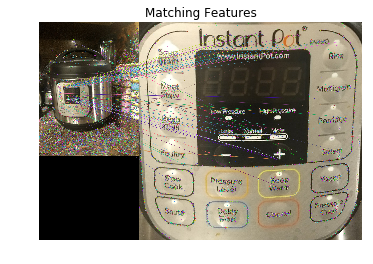

In [7]:
# Draw top matches
plot_image(cv2.drawMatches(test_img, keypoints1, panel_img, keypoints2, good, None), 'Matching Features')

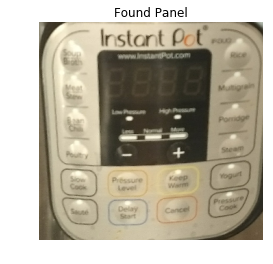

In [8]:
# Extract location of good matches
points1 = np.zeros((len(good), 2), dtype=np.float32)
points2 = np.zeros((len(good), 2), dtype=np.float32)
 
for i, match in enumerate(good):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Find homography
h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
 
# Use homography
height, width, channels = panel_img.shape
translated = cv2.warpPerspective(test_img, h, (width, height))
plot_image(translated, 'Found Panel')

## Manual tests/verification of smart_instant_pot module

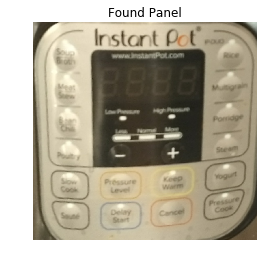

In [3]:
import cv2
import smart_instant_pot.detector as detector
panel = cv2.imread('../test_images/control_panel.jpg')
d = detector.Detector(panel)
result = d.detect_panel(cv2.imread('../test_images/test.jpg'))
if result is None:
    print('Failed to find Instant Pot in input image!')
else:
    plot_image(result, 'Found Panel')